In [0]:
#!pip3 install pyro-ppl
import pandas as pd
from pandas import Series, DataFrame, Panel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import pyro
import torchvision as tv
import matplotlib.pyplot as plt
import sklearn
from PIL import Image
%matplotlib inline

In [0]:
# Загружаем MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


In [0]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

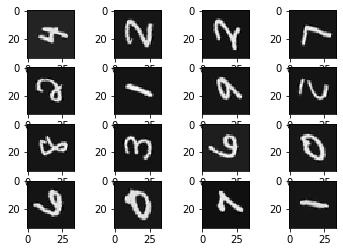

In [0]:
import scipy
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = scipy.ndimage.rotate(X[np.random.randint(0, X.shape[0]),0], 75)
    #print(I.shape)
    plt.imshow(I, cmap='gray')
#(X[np.random.randint(0, X.shape[0]),0])

In [0]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)
Y_enc = np.zeros((len(Y), 10))
for i in range(len(Y)):
  Y_enc[i, Y[i]] = 1
Y_enc

original [5 0 4 ... 4 5 6]


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
import torch
import pyro
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.autograd import Variable
import pyro.contrib.bnn as bnn
from torch.distributions import constraints

from pyro.nn import PyroModule
from pyro.nn import PyroSample

import pyro.distributions as dist

class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module('conv_1', nn.Conv2d(1, 32, kernel_size=(3,3), stride=1))
        self.net.add_module('relu_1', nn.ReLU())
        self.net.add_module('conv_2', nn.Conv2d(32, 64, kernel_size=(3,3), stride=1)) 
        self.net.add_module('relu_2', nn.ReLU())
        self.net.add_module('drop_1', nn.Dropout(0.1))                  
        self.fc1 = nn.Linear(64*24*24, 128)
        self.drop2 = nn.Dropout()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 64 * 24 * 24)
        x = self.fc2(self.drop2(self.fc1(x)))
        x = F.relu(x)
        return x

class SVINet(nn.Module):

    def __init__(self):
        super(SVINet, self).__init__()
    #    self.net = nn.Sequential()
    #    self.net.add_module('conv_1', nn.Conv2d(1, 32, kernel_size=(3,3), stride=1))
    #    self.net.add_module('relu_1', nn.ReLU())
    #    self.net.add_module('conv_2', nn.Conv2d(32, 64, kernel_size=(3,3), stride=1)) 
    #    self.net.add_module('relu_2', nn.ReLU())
    #    self.net.add_module('drop_1', nn.Dropout(0.1))                  
       # self.fc1 = nn.Linear(28*28, 128)
       # self.drop2 = nn.Dropout()
        self.fc2 =  nn.Linear(28*28, 10)


    def forward(self, x):
       # x = self.net(x)
        #x = x.view(-1, 64 * 24 * 24)
      #  x = self.drop2(F.relu(self.fc1(x)))
    # линейный слой, выход будет зависеть от реализации параметров
        x = self.fc2(x)
        # pyro.plate - итератор с именем и размером, конструкция ниже нужна для того,
        # чтобы задать условно независимые наблюдения
     #   with pyro.plate("data", x.shape[0]):
     #       obs=pyro.sample("obs", dist.Categorical(logits=mean), obs=y)
        return x

  
    #    x = x.cpu()
    #    if y is not None:
    #        y = y.cpu()
    #    x = self.fc2(x)
    #    with pyro.plate("data", x.shape[1]):
    #        obs = pyro.sample("obs", dist.Bernoulli(logits=x), obs=y) 
    #    x = x.to(torch.device(DEVICE))  
    #    if y is not None:
    #        y = y.to(torch.device(DEVICE)) 
    #    return x






class MLPNet(nn.Module):

    def __init__(self):
        super(MLPNet, self).__init__()
        self.net = nn.Sequential()                 
        self.fc1 = nn.Linear(28*28, 200)
        self.drop2 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, 28*28)
        x = self.fc2(self.drop2(self.fc1(x)))
        x = F.relu(x)
        return x


## Функция обучения модели

In [0]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro import optim
from pyro.infer import SVI, Trace_ELBO


softplus = torch.nn.Softplus()
log_softmax = nn.LogSoftmax(dim=1)



def fit_pyro_net(c_epoch,  X, Y, learning_rate = 1e-4):

    net_ = SVINet()
    
    def model_(x_data, y_data):
      fc2w_prior = dist.Normal(loc=torch.zeros_like(net_.fc2.weight), scale=torch.ones_like(net_.fc2.weight))
      fc2b_prior = dist.Normal(loc=torch.zeros_like(net_.fc2.bias), scale=torch.ones_like(net_.fc2.bias))
      priors = {'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior}
      # lift module parameters to random variables sampled from the priors
      lifted_module = pyro.random_module("module", net_, priors)
      # sample a regressor (which also samples w and b)
      lifted_reg_model = lifted_module()
      lhat = log_softmax(lifted_reg_model(x_data))
      pyro.sample("obs", dist.Categorical(logits=lhat), obs=y_data)

    def guide(x_data, y_data):
        
        # First layer weight distribution priors
        fc2w_mu = torch.randn_like(net_.fc2.weight)
        fc2w_sigma = torch.randn_like(net_.fc2.weight)
        fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
        fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
        fc2w_prior = dist.Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param)
        # First layer bias distribution priors
        fc2b_mu = torch.randn_like(net_.fc2.bias)
        fc2b_sigma = torch.randn_like(net_.fc2.bias)
        fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
        fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
        fc2b_prior = dist.Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)
        priors = {'fc2.weight': fc2w_prior, 'fc2.bias': fc2b_prior}
        lifted_module = pyro.random_module("module", net_, priors)
        
        return lifted_module()

    def predict(x):
        sampled_models = [guide(None, None) for _ in range(10)]
        yhats = [mod(x).data for mod in sampled_models]
        mean = torch.mean(torch.stack(yhats), 0)
        return np.argmax(mean.numpy(), axis=1)

    def get_logits(x):
        sampled_models = [guide(None, None) for _ in range(10)]
        yhats = [mod(x).data for mod in sampled_models]
        mean = torch.mean(torch.stack(yhats), 0)
        return mean.numpy()
  #  guide = AutoDiagonalNormal(net)

   # pyro.clear_param_store()
    adam_optimizer = optim.Adam({"lr": learning_rate})
    svi = SVI(model_, guide, adam_optimizer, loss=Trace_ELBO())
    batch_size = 300
    loss_curve = []

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_train.shape[0])
        loss_acc = 0
        acc = 0
        nbatches = X_train.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.from_numpy(X_train[batch_idxs].reshape(-1, 28*28)).float()
            y = Y_train[batch_idxs]
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
              y_enc[i, y[i]] = 1
            y = torch.from_numpy(y)
            y_enc = torch.from_numpy(y_enc)
            loss = svi.step(x, y)
      #      y_pred = predict(x)#.cpu().detach().numpy()
           # print(y_pred)
            y = Y_train[batch_idxs]
       #     acc += float(np.count_nonzero(y == y_pred))
       #     loss = loss_fn(y_pred, y)
            loss_acc += float(loss)   
        avg_epoch_loss = loss_acc / (nbatches)
       # avg_acc = acc / len(Y_train)
        
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
       # print('Do epoch %s with acc %s' % (iter, avg_acc ))
        loss_curve.append(avg_epoch_loss)
    return get_logits


def fit_net(c_epoch, net, X, Y):
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-4
    batch_size = 30
    # Оптимизатор
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss_curve = []
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    net = net.train()
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_train.shape[0])
        loss_acc = 0
        nbatches = X_train.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = Variable(torch.Tensor(X_train[batch_idxs]).to(DEVICE))
            y = Variable(torch.from_numpy(Y_train[batch_idxs]).long().to(DEVICE))
            y_pred = net(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float(loss.data)
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()    
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    net = net.eval()
    return net

def experiment_vanilla(net, X, Y, rotate=False, translate=False, blur=False):

    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = net(x).cpu().detach().numpy()
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
              y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

In [0]:
def experiment_pyro(predict, X, Y, rotate=False, translate=False, blur=False):

    batch_size = 300
    X_train,  X_test,   Y_train, Y_test= train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ]
            if translate:
                x = torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter))
            if blur:
                x = torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1))
            x = x.reshape(-1, 28*28)
            y = Y_test[batch_idxs]
            y_pred = predict(x)
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
              y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

In [0]:
DEVICE_ID = 0
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
def experiment_ensemble(nets, X, Y, rotate=False, translate=False, blur=False):

    batch_size = 30

    torch.cuda.set_device(DEVICE_ID)
    for i in range(len(nets)):
        nets[i] = nets[i].to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = np.zeros((batch_size, 10))
            for net in nets:
                y_pred += net(x).cpu().detach().numpy()
            y_pred /= len(nets)

            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
              y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier
#plt.plot(loss_curve)

In [0]:
def fit_net_T(c_epoch, net, X, Y):
    loss_fn = torch.nn.NLLLoss()
    

    learning_rate = 1e-4
    batch_size = 30
    # Оптимизатор
    
    loss_curve = []
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(DEVICE)
    
    class T_net(nn.Module):
        def __init__(self):
            super(T_net, self).__init__()
            self.T = nn.Parameter(torch.FloatTensor([1.]))
            
        def forward(self, x):
            return F.log_softmax(Variable(net(x))*self.T, -1)
    t_net = T_net().to(DEVICE)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test, test_size=0.7, random_state=97)
    optimizer = torch.optim.Adam(t_net.parameters(), lr=learning_rate)

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X_val.shape[0])
        loss_acc = 0
        nbatches = X_val.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = Variable(torch.Tensor(X_val[batch_idxs]).to(DEVICE))
            y = Variable(torch.from_numpy(Y_val[batch_idxs]).long().to(DEVICE))
            y_pred = t_net(x) # F.log_softmax(Variable(net(x))/T, -1)
            loss = loss_fn(y_pred, y)
            loss_acc += float(loss.data)
            optimizer.zero_grad()        
            loss.backward()
            optimizer.step()    
        avg_epoch_loss = loss_acc / (nbatches)
        print('T optimization: Do epoch %s with loss %s T = %s' % (iter, avg_epoch_loss, 1./t_net.T.data.item()))
        loss_curve.append(avg_epoch_loss)
    return t_net.T.data.item()

    
    

def experiment_temperature(net, X, Y, T, rotate=False, translate=False, blur=False):
    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = net(x).cpu().detach().numpy()
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], scipy.special.softmax(y_pred[i]*T))*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier

In [0]:
def experiment_dropout(net, X, Y, n_iter=10, rotate=False, translate=False, blur=False):

    batch_size = 30
    DEVICE_ID = 0
    DEVICE = torch.device('cuda:%d' % DEVICE_ID)
    torch.cuda.set_device(DEVICE_ID)
    net = net.to(torch.device(DEVICE))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=97)
    acc = []
    brier = []
    for iter in range(12):
        Xperm = np.random.permutation(X_test.shape[0])
        loss_acc = 0
        br = []
        nbatches = X_test.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = []
            if rotate:
                x = torch.Tensor(scipy.ndimage.rotate(X_test[batch_idxs], 15*iter, axes=(2,3)))
                x = Variable(x[:,:, int(x.shape[2]/2 - 14) : int(x.shape[2]/2 + 14), int(x.shape[3]/2 - 14) : int(x.shape[2]/2 + 14) ].to(DEVICE))
            if translate:
                x = Variable(torch.Tensor(np.roll(X_test[batch_idxs], axis=(2,3), shift=2*iter)).to(DEVICE))
            if blur:
                x = Variable(torch.Tensor(scipy.ndimage.filters.gaussian_filter(X_test[batch_idxs], sigma=iter*0.1)).to(DEVICE))
         #   print(x.shape)
            y = Y_test[batch_idxs]
            y_pred = np.zeros((batch_size, 10))
            for it in range(n_iter):
                y_pred += scipy.special.softmax(net(x).cpu().detach().numpy(), -1)
            y_pred /= n_iter
            
            loss_acc += np.count_nonzero(y == np.argmax(y_pred, axis=1))
            y_enc = np.zeros((len(y), 10))
            for i in range(len(y)):
                y_enc[i, y[i]] = 1
            br += [brier_score_loss(y_enc[i], y_pred[i])*10 for i in range(batch_size)]
        loss_acc /= len(Y_test)
        brier.append(np.mean(np.array(br)))
        acc.append(loss_acc)

    return acc, brier

### Обучаем модели


In [0]:
   
net = LeNet()
model = fit_net(10, net, X, Y)
loss_curve_translate_vanilla , brier_curve_translate_vanilla = experiment_vanilla(model, X,Y, translate=True)
loss_curve_rotate_vanilla , brier_curve_rotate_vanilla = experiment_vanilla(model, X,Y, rotate=True)
loss_curve_blur_vanilla , brier_curve_blur_vanilla = experiment_vanilla(model, X,Y, blur=True)

Do epoch 0 with loss 0.9468103745895601
Do epoch 1 with loss 0.07441920715453186
Do epoch 2 with loss 0.043999488072079346
Do epoch 3 with loss 0.03023916351148601
Do epoch 4 with loss 0.022428495369528526
Do epoch 5 with loss 0.020095130434653313
Do epoch 6 with loss 0.015162016929383959
Do epoch 7 with loss 0.013659407496932058
Do epoch 8 with loss 0.01219035125341562
Do epoch 9 with loss 0.011457490162744815


LeNet(
  (net): Sequential(
    (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu_1): ReLU()
    (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu_2): ReLU()
    (drop_1): Dropout(p=0.1, inplace=False)
  )
  (fc1): Linear(in_features=36864, out_features=128, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [51]:
net = LeNet()
net_v = fit_net(10, net, X, Y)
model_v = net_v.eval()
T = fit_net_T(20, model_v, X, Y)
loss_curve_translate_temp, brier_curve_translate_temp = experiment_temperature(model_v, X,Y,T, translate=True)
loss_curve_rotate_temp, brier_curve_rotate_temp = experiment_temperature(model_v, X,Y,T, rotate=True)
loss_curve_blur_temp , brier_curve_blur_temp = experiment_temperature(model_v, X,Y,T, blur=True)

Do epoch 0 with loss 0.7722038392107066
Do epoch 1 with loss 0.07162654952070219
Do epoch 2 with loss 0.042991438491458915
Do epoch 3 with loss 0.030092391406644176
Do epoch 4 with loss 0.02203097094547457
Do epoch 5 with loss 0.01839810498999889
Do epoch 6 with loss 0.016026237468692157
Do epoch 7 with loss 0.014201826073883322
Do epoch 8 with loss 0.011946690580309362
Do epoch 9 with loss 0.011557233232697514
T optimization: Do epoch 0 with loss 0.06775772568151461 T = 1.0049317512356033
T optimization: Do epoch 1 with loss 0.06745281198127775 T = 1.0107736346251874
T optimization: Do epoch 2 with loss 0.06713775257587876 T = 1.0167936980814318
T optimization: Do epoch 3 with loss 0.0668257354830296 T = 1.022736810175128
T optimization: Do epoch 4 with loss 0.06650922035439798 T = 1.0288332683000356
T optimization: Do epoch 5 with loss 0.06619550735886638 T = 1.0348749669145905
T optimization: Do epoch 6 with loss 0.06588601443149693 T = 1.041078607341815
T optimization: Do epoch 7 w

In [52]:
net = LeNet()
net_v = fit_net(10, net, X, Y)
loss_curve_translate_drop, brier_curve_translate_drop = experiment_dropout(net_v, X,Y, translate=True)
loss_curve_rotate_drop, brier_curve_rotate_drop = experiment_dropout(net_v, X,Y, rotate=True)
loss_curve_blur_drop , brier_curve_blur_drop = experiment_dropout(net_v, X,Y, blur=True)

Do epoch 0 with loss 1.6141991323372449
Do epoch 1 with loss 0.0916645798467772
Do epoch 2 with loss 0.049724530367851245
Do epoch 3 with loss 0.032858027401870764
Do epoch 4 with loss 0.02676622438519585
Do epoch 5 with loss 0.02191584481666113
Do epoch 6 with loss 0.01749639775052885
Do epoch 7 with loss 0.014608382993885262
Do epoch 8 with loss 0.013874213175673764
Do epoch 9 with loss 0.01242749988652316


In [0]:

model = fit_pyro_net(20, X, Y, learning_rate = 0.01)
loss_curve_translate_svi , brier_curve_translate_svi = experiment_pyro(model, X,Y, translate=True)
loss_curve_rotate_svi , brier_curve_rotate_svi = experiment_pyro(model, X,Y, rotate=True)
loss_curve_blur_svi , brier_curve_blur_svi = experiment_pyro(model, X,Y, blur=True)

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:368: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Do epoch 0 with loss 19425.806469584026
Do epoch 1 with loss 19288.98343702029
Do epoch 2 with loss 19461.91901982215
Do epoch 3 with loss 19205.798156530625
Do epoch 4 with loss 19389.70899156601
Do epoch 5 with loss 19403.709719698916
Do epoch 6 with loss 19571.15214549085
Do epoch 7 with loss 19355.735602348082
Do epoch 8 with loss 19230.564247059567
Do epoch 9 with loss 19211.272104017196
Do epoch 10 with loss 19470.019106516273
Do epoch 11 with loss 19442.481363886145
Do epoch 12 with loss 19218.401121103634
Do epoch 13 with loss 19356.230804658706
Do epoch 14 with loss 19765.584448019665
Do epoch 15 with loss 19201.072038686405
Do epoch 16 with loss 19116.03138954409
Do epoch 17 with loss 19128.915219763272
Do epoch 18 with loss 18889.017978852797
Do epoch 19 with loss 19327.306315017002


In [0]:
nets = []
for i in range(10):
    net = LeNet()
    nets.append(fit_net(10, net, X, Y))
loss_curve_translate_ensemble , brier_curve_translate_ensemble = experiment_ensemble(nets, X,Y, translate=True)
loss_curve_rotate_ensemble , brier_curve_rotate_ensemble = experiment_ensemble(nets, X,Y, rotate=True)
loss_curve_blur_ensemble , brier_curve_blur_ensemble = experiment_ensemble(nets, X,Y, blur=True)

Do epoch 0 with loss 0.5825971154322511
Do epoch 1 with loss 0.061413476835307255
Do epoch 2 with loss 0.03980884182677035
Do epoch 3 with loss 0.027387533280332207
Do epoch 4 with loss 0.021261536344888907
Do epoch 5 with loss 0.021007958358337662
Do epoch 6 with loss 0.015609944124838493
Do epoch 7 with loss 0.015000187918892472
Do epoch 8 with loss 0.013244615545807437
Do epoch 9 with loss 0.011616633114946356
Do epoch 0 with loss 0.812145724476054
Do epoch 1 with loss 0.07049283506090444
Do epoch 2 with loss 0.04181276746699933
Do epoch 3 with loss 0.029137157782938527
Do epoch 4 with loss 0.02249220040730538
Do epoch 5 with loss 0.016699725394652296
Do epoch 6 with loss 0.015240130807866672
Do epoch 7 with loss 0.013159024683932036
Do epoch 8 with loss 0.011737966307099485
Do epoch 9 with loss 0.013010327896347743
Do epoch 0 with loss 1.2584001418104669
Do epoch 1 with loss 0.08789898018643616
Do epoch 2 with loss 0.05140694469038457
Do epoch 3 with loss 0.037079941060262626
Do ep

 ## Результаты

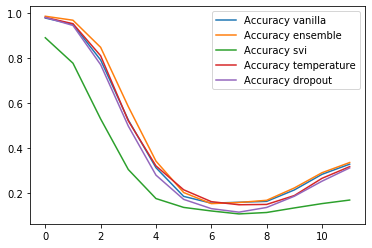

In [53]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_rotate_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_rotate_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_rotate_svi,label="Accuracy svi")
ax.plot(loss_curve_rotate_temp,label="Accuracy temperature")
ax.plot(loss_curve_rotate_drop,label="Accuracy dropout")
ax.legend()
plt.show()

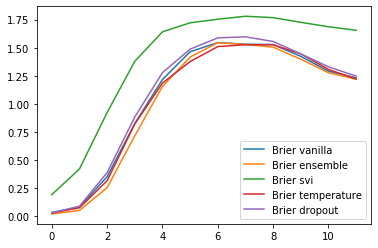

In [54]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_rotate_vanilla,label="Brier vanilla")
ax.plot(brier_curve_rotate_ensemble,label="Brier ensemble")
ax.plot(brier_curve_rotate_svi,label="Brier svi")
ax.plot(brier_curve_rotate_temp,label="Brier temperature")
ax.plot(brier_curve_rotate_drop,label="Brier dropout")
ax.legend()
plt.show()

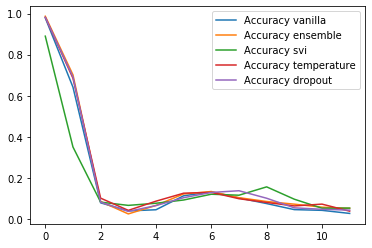

In [55]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_translate_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_translate_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_translate_svi,label="Accuracy svi")
ax.plot(loss_curve_translate_temp,label="Accuracy temperature")
ax.plot(loss_curve_translate_drop,label="Accuracy dropout")
ax.legend()
plt.show()

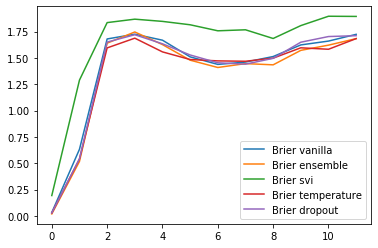

In [56]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_translate_vanilla,label="Brier vanilla")
ax.plot(brier_curve_translate_ensemble,label="Brier ensemble")
ax.plot(brier_curve_translate_svi,label="Brier svi")
ax.plot(brier_curve_translate_temp,label="Brier temperature")
ax.plot(brier_curve_translate_drop,label="Brier dropout")
ax.legend()
plt.show()

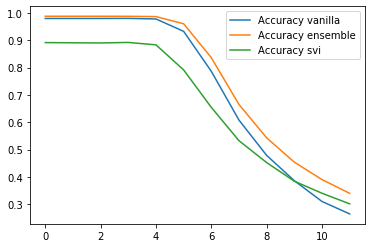

In [0]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_blur_vanilla,label="Accuracy vanilla")
ax.plot(loss_curve_blur_ensemble,label="Accuracy ensemble")
ax.plot(loss_curve_blur_svi,label="Accuracy svi")
ax.plot(loss_curve_blur_temp,label="Accuracy temperature")
ax.plot(loss_curve_blur_drop,label="Accuracy dropout")
ax.legend()
plt.show()

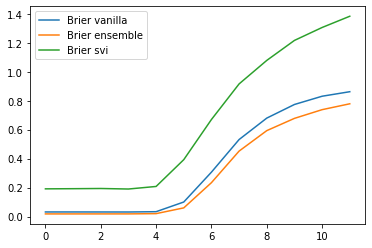

In [0]:
ax = plt.subplot(1,1,1)
ax.plot(brier_curve_blur_vanilla,label="Brier vanilla")
ax.plot(brier_curve_blur_ensemble,label="Brier ensemble")
ax.plot(brier_curve_blur_svi,label="Brier svi")
ax.plot(brier_curve_blur_temp,label="Brier temperature")
ax.plot(brier_curve_blur_drop,label="Brier dropout")
ax.legend()
plt.show()